# **2-3. 베이지안 최적화 (공학 예제)**

---


By Mingyu Lee and Ikjin Lee

http://idol.kaist.ac.kr/

mglee91@kaist.ac.kr

https://scholar.google.co.kr/citations?hl=ko&user=yDYefB8AAAAJ&view_op=list_works&sortby=pubdate

https://github.com/MingyuLee91

IDOL Lab at KAIST



---

### **< Source papers >**

* **Lee, M.**, Jung, Y., Choi, J., & **Lee, I.** (2022). A reanalysis-based multi-fidelity (RBMF) surrogate framework for efficient structural optimization. Computers & Structures, 273, 106895.
* Lee, J., Park, D., **Lee, M.**, Lee, H., Park, K., **Lee, I.**, & Ryu, S. (2023). Machine learning-based inverse design methods considering data characteristics and design space size in materials design and manufacturing: a review. Materials Horizons.
* **Lee, M.**, Noh, Y., & **Lee, I.** (2024). A novel sampling method for adaptive gradient-enhanced Kriging. Computer Methods in Applied Mechanics and Engineering, 418, 116456.
* Lee, J., **Lee, M.**, Lee, B. J., & **Lee, I.** (2024). A comprehensive multi-fidelity surrogate framework based on Gaussian process for datasets with heterogeneous responses. Knowledge-Based Systems, 295, 111827.
* **Lee, M.**, Jung, Y., Hwang, C., Kim, M., Kim, M., Lee, U., & **Lee, I.** (2024). An efficient multi-fidelity design optimization framework for a thermoelectric generator system. Energy Conversion and Management, 315, 118788.


Original source codes from https://github.com/SMTorg/SMT

Related documentation https://smt.readthedocs.io/en/latest/#

Modified version by Mingyu Lee

---


### **< Contents >**

 1) Optimization algorithm (1D benchmark example)

 2-1) Kriging model (1D benchmark example)

 2-2) Bayesian optimization (1D benchmark example)

**2-3) Bayesian optimization (5D engineering example)**

**참고:** https://seong6496.tistory.com/317 (Data를 Google drive에 mount하는 방법)

In [1]:
!pip install smt

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 21.1.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## **▣ 실습: Engineering application**

### ※ **공학문제 실습**

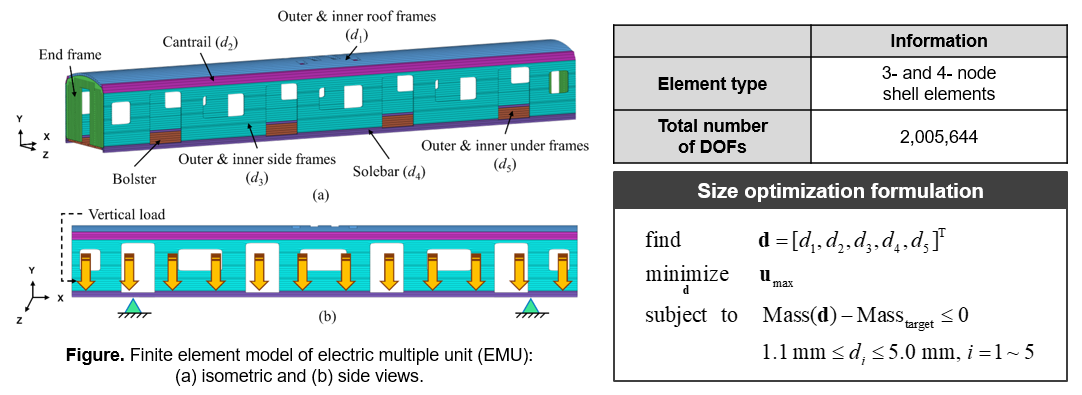

### ※ **예제 문제**
* **실습목표:** 공학 예제를 이용한 베이지안 최적화 수행
* **설계변수:** 전동차 각 파트의 쉘 두께 (5개)
* **설계공간:** 1.1<x<sub>1</sub><5, 1.1<x<sub>2</sub><5, 1.1<x<sub>3</sub><5, 1.1<x<sub>4</sub><5, 1.1<x<sub>5</sub><5
* **초기설계:** 모두 3.5 mm
* **목적함수:** Bending loading condition일때 solebar의 수직방향으로의 처짐량을 최소화
* **제한조건:** 정규화된 전동차의 무게 <= 0.85

In [2]:
from __future__ import print_function, division
import numpy as np
from scipy import linalg

from smt.problems import Sphere, NdimRobotArm, Rosenbrock
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS, MGP
try:
    from smt.surrogate_models import IDW, RBF, RMTC, RMTB
    compiled_available = True
except:
    compiled_available = False

try:
    import matplotlib.pyplot as plt
    plot_status = True
except:
    plot_status = False

import scipy.interpolate

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

from scipy.stats import norm
from scipy.optimize import minimize, differential_evolution
import numpy as np
import matplotlib.pyplot as plt

## **Steps 1-3: Training data 불러오기**

In [3]:
# 인풋&아웃풋 데이터 불러오기
Data= np.array([[ 3.18526542, 2.11776589, 3.27774438, 1.33224192, 1.98143467,18.69066769],
       [ 1.24589381, 4.67175462, 1.96342476, 1.97002309, 3.01940674, 16.14181721],
       [ 4.711109  , 4.7917362 , 4.11716604, 2.27151478, 3.996545  , 10.86516546],
       [ 4.93290318, 3.43240273, 1.78446647, 4.27744655, 2.71057275, 14.35790137],
       [ 3.85373284, 1.63849792, 3.70312468, 3.77409036, 4.33005241, 13.28897247],
       [ 3.54532702, 2.47011398, 1.61018789, 3.46503265, 1.83244016, 18.29506334],
       [ 2.33182495, 2.79296167, 2.16985632, 1.64836015, 2.33761768, 18.8469311 ],
       [ 4.3232608 , 4.32958348, 3.46254542, 4.13311761, 1.1295069 , 12.20786515],
       [ 2.4750839 , 1.29830627, 4.53299219, 2.47832608, 2.65254472, 16.01053411],
       [ 1.82234585, 1.5006993 , 1.33433481, 1.56856945, 3.83262564, 25.72986326],
       [ 4.18947141, 2.14959698, 4.93191349, 4.99205935, 3.39633894, 10.83642814],
       [ 2.84286427, 3.81783051, 4.39280722, 4.54654069, 4.74554303, 9.8083907 ],
       [ 2.05711764, 4.08450468, 3.00327073, 2.78999417, 3.51469944, 12.93187541],
       [ 3.06971664, 3.63978546, 2.62449618, 3.31522024, 1.48987738, 14.58052619],
       [ 1.48795685, 3.05288659, 2.73248085, 2.94477222, 4.61751702, 14.00695652]])

In [4]:
# 인풋 데이터
xt = Data[:,:5]
print(xt) # 인풋 데이터

[[3.18526542 2.11776589 3.27774438 1.33224192 1.98143467]
 [1.24589381 4.67175462 1.96342476 1.97002309 3.01940674]
 [4.711109   4.7917362  4.11716604 2.27151478 3.996545  ]
 [4.93290318 3.43240273 1.78446647 4.27744655 2.71057275]
 [3.85373284 1.63849792 3.70312468 3.77409036 4.33005241]
 [3.54532702 2.47011398 1.61018789 3.46503265 1.83244016]
 [2.33182495 2.79296167 2.16985632 1.64836015 2.33761768]
 [4.3232608  4.32958348 3.46254542 4.13311761 1.1295069 ]
 [2.4750839  1.29830627 4.53299219 2.47832608 2.65254472]
 [1.82234585 1.5006993  1.33433481 1.56856945 3.83262564]
 [4.18947141 2.14959698 4.93191349 4.99205935 3.39633894]
 [2.84286427 3.81783051 4.39280722 4.54654069 4.74554303]
 [2.05711764 4.08450468 3.00327073 2.78999417 3.51469944]
 [3.06971664 3.63978546 2.62449618 3.31522024 1.48987738]
 [1.48795685 3.05288659 2.73248085 2.94477222 4.61751702]]


In [5]:
# 아웃풋 데이터
yt = Data[:,5:]
print(yt) # 아웃풋 데이터

[[18.69066769]
 [16.14181721]
 [10.86516546]
 [14.35790137]
 [13.28897247]
 [18.29506334]
 [18.8469311 ]
 [12.20786515]
 [16.01053411]
 [25.72986326]
 [10.83642814]
 [ 9.8083907 ]
 [12.93187541]
 [14.58052619]
 [14.00695652]]


In [6]:
# 차원 및 초기 데이터 개수
ndoe = xt.shape[0] # 초기 데이터 개수
ndim = xt.shape[1] # 설계 변수 개수 (차원)
print("Training data 개수",ndoe)
print("설계변수 개수",ndim)

Training data 개수 15
설계변수 개수 5


## **Step 4: 대리 모델 구성 (Single-fidelity prediction model: Kriging)**

In [7]:
# 대리모델링 (Main process)
initial_theta = [1e-2]*ndim # 초기 하이퍼파라미터 설정
sm = KRG(theta0 = initial_theta,print_prediction = False)
sm.set_training_values(xt,yt[:,0]) # 하이퍼파라미터 최적화
sm.train() # 하이퍼파라미터 최적화

# 하이퍼파라미터 변화
print("initial theta values",  initial_theta)
print("optimal theta values",  sm.optimal_theta)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 15
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2263951
initial theta values [0.01, 0.01, 0.01, 0.01, 0.01]
optimal theta values [0.00011331 0.0536155  0.02422117 0.05974524 0.00170043]


## **Step 5: Sequential sampling 프로세스**

In [8]:
# Acquisition function 선택 (대리모델 업데이트)
# Criterion = "SP" # Surrogate predictor
# Criterion = "MSE" # Mean-squared error
Criterion = "EI" # Expected improvement
# Criterion = "LCB" # Lower confidence bound

In [9]:
# Iterative process
# Maximum_sample_number = 10
# n_iterations = Maximum_sample_number-xt.shape[0] # 추가시킬 샘플의 개수
n_iterations = 1 # 추가시킬 샘플의 개수

In [10]:
bound_values = [(1.1,5),(1.1,5),(1.1,5),(1.1,5),(1.1,5)] # 경계값
initial_points = np.array([3.0, 3.0, 3.0, 3.0, 3.0], dtype = 'float64') # 초기값

In [11]:
# 목적함수
##########################################################################################################
# Acquisition function 정의 (Surrogate predictor)
def SP_function(x, sm):

    # Predict the mean and variance at point x
    y_pred = sm.predict_values(x) # 예측값 (평균)

    return y_pred[0]

##########################################################################################################
# Acquisition function 정의 (Mean-squared error)
def MSE_function(x, sm):

    # Predict the mean and variance at point x
    y_s2 = sm.predict_variances(x) # 불확실 정보 (분산)

    return y_s2[0]

##########################################################################################################
# Acquisition function 정의 (Expected improvement)
def EI_function(x, sm, yt):
    y_min = np.min(yt) # 샘플링된 출력값 중에 최소값
    # Predict the mean and variance at point x
    y_pred = sm.predict_values(x) # 예측값 (평균)
    y_s2 = sm.predict_variances(x) # 불확실 정보 (분산)

    # Avoid division by zero
    y_s = np.sqrt(y_s2) # 표준편차
    y_s = np.maximum(y_s, 1e-16) # 수치 문제 해결을 위한 trick

    # EI calculation
    EI_value = (y_min - y_pred)*norm.cdf((y_min - y_pred)/y_s) + y_s * norm.pdf((y_min - y_pred)/y_s)

    return EI_value[0]

##########################################################################################################
# Acquisition function 정의 (Lower-confidence bound)
def LCB_function(x, sm):

    # Predict the mean and variance at point x
    y_pred = sm.predict_values(x) # 예측값 (평균)
    y_s2 = sm.predict_variances(x) # 불확실 정보 (분산)
    y_s = np.sqrt(y_s2) # 표준편차

    # LCB calculation
    A = 1; # User-defined parameter (Generally, 1~4)
    LCB_value = y_pred - A*y_s

    return LCB_value[0]

##########################################################################################################

In [12]:
def constr(x): # 제한조건함수
    x = x[np.newaxis,:]
    return -(1.3*x[0,0]+1*x[0,1]+3*x[0,2]+1.1*x[0,3]+3.8*x[0,4])/30+1

ineq_cons = {'type': 'ineq', 'fun': constr} # 제한조건 설정

In [13]:
# Sequential sampling process 수행
for iteration in range(n_iterations):

    # Acquisition function에 대한 최적화 수행
    if Criterion == "SP":
        result = minimize(lambda x: SP_function(x.reshape(1, -1), sm),initial_points,method='SLSQP',bounds=bound_values,constraints=ineq_cons) # Minimizing the SP function

    elif Criterion == "MSE":
        result = minimize(lambda x: -MSE_function(x.reshape(1, -1), sm),initial_points,method='SLSQP',bounds=bound_values,constraints=ineq_cons) # Maximizing the MSE function

    elif Criterion == "EI":
        result = minimize(lambda x: -EI_function(x.reshape(1, -1), sm, yt),initial_points,method='SLSQP',bounds=bound_values,constraints=ineq_cons) # Maximizing the EI function

    elif Criterion == "LCB":
        result = minimize(lambda x: LCB_function(x.reshape(1, -1), sm),initial_points,method='SLSQP',bounds=bound_values,constraints=ineq_cons) # Minimizing the LCB function


    x_opt = result.x.reshape(1, -1)  # x_opt를 2D 배열로 변환

    # f_opt = Black_box_model(x_opt).reshape(1, -1) # 실제 black-box model에서 output이 계산 되는 스텝 (FEA, CFD, Experiment)

    # # 새로운 샘플 추가
    # xt = np.vstack((xt, x_opt)) # input data 업데이트
    # yt = np.vstack((yt, f_opt)) # output data 업데이트
    # y_min_array = np.vstack((y_min_array, np.min(yt)))

    # sm = KRG(theta0=initial_theta, print_global=False)
    # sm.set_training_values(xt, yt)  # 누적된 샘플로 대리모델 학습
    # sm.train()  # 하이퍼파라미터 최적화

In [14]:
result

     fun: array([-1.41848069e-230])
     jac: array([-7.46451004e-189,  3.95041764e-189, -3.44001601e-188,
       -4.64853096e-189,  1.05760859e-189])
 message: 'Optimization terminated successfully'
    nfev: 7
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([2.97147038, 2.97805413, 2.9341624 , 2.97585955, 2.9166057 ])

In [15]:
x_opt = result.x
print("Next candidate input",x_opt)

Next candidate input [2.97147038 2.97805413 2.9341624  2.97585955 2.9166057 ]
